In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import json
import pandas as pd
from scipy import signal, stats
import numpy as np
import seaborn as sns

Matplotlib created a temporary cache directory at /tmp/matplotlib-dlqd0drt because the default path (/afs/csail.mit.edu/u/c/czw/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


The quick start guide assumes the following directory structure
```
braintreebank_data
|_ all_subject_data
    |_ sub_<sub_id>_trial<trial_id>.h5 <-- neural recordings
|_ subject_timings
    |_ sub_<sub_id>_trial<trial_id>_timings.csv <-- sync btwn recordings and wall clock
|_ subject_metadata
    |_sub_<sub_id>_trial<trial_id>_metadata.csv <-- contains movie title
|_ transcripts
    |_<movie_id>/features.csv <-- pre-computed features
|_electrode_labels
    |_sub_<sub_id>/electrode_labels.csv <-- semantic labels for electrodes
```

For this quickstart, download the above files. However, all neural recordings are not needed for this tutorial. Just `sub_3_trial000.h5`

In [2]:
root_dir = "../braintreebank_data/"
sub_id = 3
trial_id = 0

# Path to neural data h5 file
neural_data_file = os.path.join(f"{root_dir}/all_subject_data/", f'sub_{sub_id}_trial{trial_id:03}.h5')

# Path to trigger times csv file
trigger_times_file = os.path.join(root_dir, f'subject_timings/sub_{sub_id}_trial{trial_id:03}_timings.csv')

# Path format to trial metadata json file
metadata_file = os.path.join(root_dir, f'subject_metadata/sub_{sub_id}_trial{trial_id:03}_metadata.json')

with open(metadata_file, 'r') as f:
    meta_dict = json.load(f)
    title = meta_dict['title']
    print(f'Movie name for the given subject and trial is: {title}')
    movie_id = meta_dict['filename']
    
# # Path to transcript csv file
transcript_file_format = os.path.join(root_dir, f'transcripts/{movie_id}/features.csv')

# Path format to electrode labels file -- mapping each ID to an subject specific label
electrode_labels_file = os.path.join(root_dir, f'electrode_labels/sub_{sub_id}/electrode_labels.json')

Movie name for the given subject and trial is: Cars 2


A trial h5 data file will contain all the neural data collected during the presentation of the movie

There are $n$ rows (h5 calls them groups) in each file, where $n$ is the number of electrodes. Each row is a $1\times T$ array where $T$ is the length of the recording.

In [3]:
electrode_num = 68

samp_frequency = 2048  # sampling frequency of sEEG
h5f = h5py.File(neural_data_file, 'r')
data = h5f['data']
electrode_data = data[f"electrode_{electrode_num}"]
electrode_data.shape

(14017056,)

This is how 3 seconds of signal looks like for a single electrode:

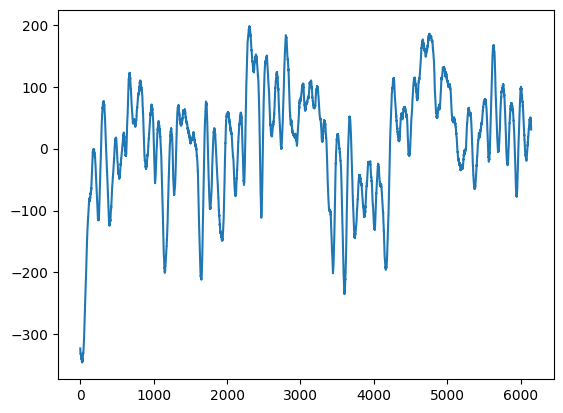

In [4]:
time_in_seconds = 60
duration_in_sec = 3

plt.plot(electrode_data[time_in_seconds * samp_frequency:(time_in_seconds + duration_in_sec) * samp_frequency])

We map each electrode ID to a label

In [5]:
with open(electrode_labels_file, "r") as f:
    electrode_labels = json.load(f)

In [6]:
len(electrode_labels)

136

In [7]:
electrode_label = electrode_labels[electrode_num]

All computer induced triggers are logged in the trigger times csv file

The relevant columns for downstream processing are: 
**type:** the type of trigger token sent (movie beginning/end/pause/unpause). <br>
**movie time:** the movie time in which a trigger was sent (will always begin from zero). <br>
**start time:** real time (wall clock time) in which a trigger was sent (while movie time remains the same during movie pauses, real time will continue to count). <br>
**index:** the neural data sample that recorded the beginning of the trigger. <br>

In [8]:
trigs_df = pd.read_csv(trigger_times_file)
trigs_df.head()

,type,movie_time,start_time,end_time,trig_type,index,diff
0,beginning,0.000000,151498.821018,151499.746235,manual,723127,2042
1,trigger,0.083417,151499.817793,151499.834710,high_real,725169,372
2,trigger,0.208542,151499.998980,151500.015133,high_real,725541,136
3,trigger,0.291959,151500.064948,151500.082124,high_real,725677,274
4,trigger,0.417084,151500.198573,151500.214487,high_real,725951,168


Each trial directory contains a metadata file with the movie id that was presented during the trial

A movie transcript csv file will contain all features that were annotated from the video, audio and language of each movie, including the manually annotated word times

In [9]:
words_df = pd.read_csv(transcript_file_format.format(movie_id)).set_index('Unnamed: 0')
words_df.head()

,text,lemma,pos,deprel,start,end,sentence,head,bin_head,sentence_idx,...,max_mean_pixel_difference,min_mean_pixel_difference,max_global_magnitude,max_global_angle,max_vector_magnitude,max_vector_angle,face_num,max_mean_magnitude,max_median_magnitude,speaker
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,This,this,PRON,nsubj,47.150,47.32,This is Agent Leland Turbo.,4,1,0,...,0.780484,0.263890,0.129278,343.678017,50.869549,358.020782,0.0,0.169803,0.0,Leland Turbo
1,is,be,AUX,cop,47.321,47.42,This is Agent Leland Turbo.,4,1,0,...,0.505967,0.219717,0.077011,299.866566,29.721148,358.020782,0.0,0.108349,0.0,Leland Turbo
2,Agent,Agent,NOUN,compound,47.421,47.71,This is Agent Leland Turbo.,4,1,0,...,0.391508,0.199268,0.088891,291.044357,19.945601,358.020782,1.0,0.104377,0.0,Leland Turbo
3,Leland,leland,PROPN,root,47.791,48.06,This is Agent Leland Turbo.,0,0,0,...,0.902182,0.143418,0.312056,279.164497,22.096857,339.400940,0.0,0.339084,0.0,Leland Turbo
4,Turbo,Turbo,PROPN,flat,48.061,48.36,This is Agent Leland Turbo.,4,0,0,...,0.902182,0.146539,0.312056,280.199287,22.096857,348.823425,0.0,0.339084,0.0,Leland Turbo


In [10]:
words_df = words_df.dropna().reset_index(drop=True)  # no need to keep word particles identified by NaN word times

In [11]:
# Data frames column IDs
start_col = 'start'
end_col = 'end'
lbl_col = 'pos'
trig_time_col = 'movie_time'
trig_idx_col = 'index'
est_idx_col = 'est_idx'
est_end_idx_col = 'est_end_idx'
word_time_col = 'word_time'
word_text_col = 'text'
is_onset_col = 'is_onset'
is_offset_col = 'is_offset'

In [12]:
def notch_filter(data, freq, Q=30):
    """
    Run notch filtering on a given signal.
    
    Inputs:
    data - pre-filtered signals
    freq - frequency band to filter out
    
    Output:
    The original data without the given frequency componant.
    """
    w0 = freq / (samp_frequency / 2)  # Normalized Frequency
    b, a = signal.iirnotch(w0, Q) # Design notch filter
    y = signal.lfilter(b, a, data, axis=0) # remove frequancy
    return y

data_arr = electrode_data[:]  # extracts a numpy array from h5 dataset (may take a few minutes)
print('Removing 60Hz and harmonics...')
for f in [60, 120, 180, 240, 300, 360]:
    data_arr = notch_filter(data_arr, f)
    print('Filtered {}Hz'.format(f))

Removing 60Hz and harmonics...
Filtered 60Hz
Filtered 120Hz
Filtered 180Hz
Filtered 240Hz
Filtered 300Hz
Filtered 360Hz


By comparing the annotated word and trigger times (movie time) we can find the closest trigger and estimate the most likely word onset data sample by interpolation

In [13]:
def estimate_sample_index(t, near_t, near_trig):
    """
    Estimates the word onset data sample by interpolation from nearest trigger.
    
    Inputs:
    t - word movie time
    near_t - nearest trigger movie time
    near_trig - nearest trigger sample index
    
    Output:
    Estimated word onset sample index
    """
    trig_diff = (t - near_t) * samp_frequency
    return round(near_trig + trig_diff)


def add_estimated_sample_index(w_df, t_df):
    """
    Computes and adds data sample indices to annotated movie word onsets by interpolation from nearest trigger.
    
    Inputs:
    w_df - movie annotated words data frame
    t_df - computer triggers data frame
    
    Output:
    Movie annotated words data frame augmented with estimated data sample indices
    """
    tmp_w_df = w_df.copy(deep=True)
    last_t = t_df.loc[len(t_df) - 1, trig_time_col]
    for i, t, endt in zip(w_df.index, w_df[start_col], w_df[end_col]):
        if t > last_t:  # if movie continues after triggers
            break
        idx = (abs(t_df[trig_time_col] - t)).idxmin()  # find nearest movie time index
        tmp_w_df.loc[i, :] = w_df.loc[i, :]
        tmp_w_df.loc[i, est_idx_col] = \
                estimate_sample_index(t, t_df.loc[idx, trig_time_col], t_df.loc[idx, trig_idx_col])

        end_idx = (abs(t_df[trig_time_col] - endt)).idxmin()  # find nearest movie time index
        tmp_w_df.loc[i, est_end_idx_col] = \
                estimate_sample_index(endt, t_df.loc[end_idx, trig_time_col], t_df.loc[end_idx, trig_idx_col])

    return tmp_w_df

In [14]:
words_df = add_estimated_sample_index(words_df, trigs_df)  # align all words to data samples
words_df.head()  # aligned sample indices were added to last two columns
words_df = words_df.dropna().reset_index(drop=True)  # no need to keep words with no start time

After alignment we can extract context windows arround each annotated word

In [15]:
duration = 3  # time after word onset in seconds
delta = -1  # time shift from word onset in seconds

window_duration = int(duration * samp_frequency)
window_onset = int(delta * samp_frequency)

print('Generating aligned predictor matrix of size {}'\
      .format((1, len(words_df.index), window_duration)))
word_windows_arr = np.empty((1, len(words_df.index), window_duration))

for i in words_df.index:
    row = words_df.loc[i]
    try:
        word_windows_arr[0, i, :] = data_arr[int(row[est_idx_col]) + window_onset: \
                                             int(row[est_idx_col] + window_duration + window_onset)]
    except ValueError as err:
        print('Neural recording stopped before movie ended.')
        break

Generating aligned predictor matrix of size (1, 10118, 6144)


We can now plot neural signal recordings of multiple word instances across any electrode

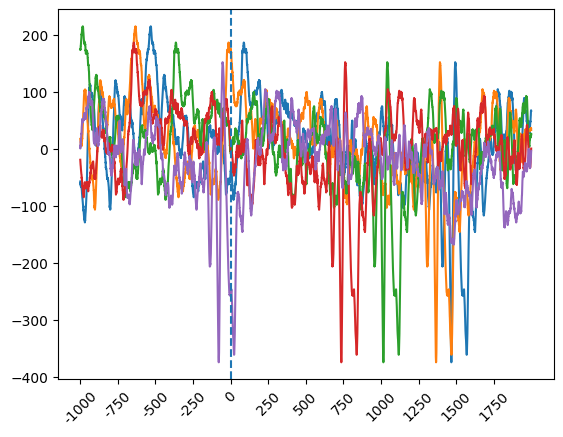

In [16]:
# We can now plot neural signal recordings of multiple word instnaces across any electrode
fig, ax = plt.subplots()
plt.plot(word_windows_arr[0, :5, :].transpose())
ax.set_xticks(np.arange(0, window_duration, 512))
ax.set_xticklabels((np.arange(window_onset, window_duration + window_onset, 512) / (samp_frequency / 1000))
                       .astype(int), rotation=45)
ax.axvline(x=-window_onset, ls='--')
plt.show()

But they're a mess...

To make sense of these signals and get preliminary indication for language responsiveness we need to stack and average the word aligned recorded signals per electrode

In [17]:
def plot_raster(ax, data, duration_idxs, delta_idxs):
    vmax = 300
    ax.set_xticks(np.arange(0, duration_idxs, 512))
    ax.set_xticklabels((np.arange(delta_idxs, duration_idxs + delta_idxs, 512) / (samp_frequency / 1000))
                       .astype(int), rotation=45)

    pos = ax.imshow(data, cmap='bwr', vmin=-vmax, vmax=vmax)
    ax.axvline(x=-delta_idxs, color='k')
    ax.set_aspect('auto')

def plot_mean(ax, data, duration_idxs, delta_idxs):
    ax.set_xticks(np.arange(0, duration_idxs, 512))
    ax.set_xticklabels((np.arange(delta_idxs, duration_idxs + delta_idxs, 512) / (samp_frequency / 1000))
                       .astype(int), rotation=45)
    vrr = np.mean(data, axis=0)
    vsemrr = np.std(data, axis=0) / np.sqrt(data.shape[0])
    pos = ax.plot(vrr,'k-')
    ax.fill_between(np.arange(0, duration_idxs), vrr - vsemrr, vrr + vsemrr)

    ax.axvline(x=vrr.argmax(), color='gray', ls='--')
    ax.axhline(y=vrr.max(), color='gray', ls='--')
    ax.axhline(y=0, color='k')
    ax.axvline(x=-delta_idxs, color='k')
    ax.set_ylim(-100, 120)
    ax.set_xlim(0, duration_idxs)
    ax.set_aspect('auto')
        
def plot_overlaid_electrode_signal(full_data, words_df, label, duration, delta):
    data = full_data[0]
    event_df = words_df.copy(deep=True)
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex=True)

    # split words by in-sentence location
    event_df[is_onset_col] = np.zeros(len(event_df))
    event_df.loc[event_df.idx_in_sentence == 0, is_onset_col]= 1
    event_df[is_offset_col] = event_df[is_onset_col].shift(-1)
    event_df.loc[len(event_df) - 1, is_offset_col] = 1

    onset_idxs = np.where(event_df[is_onset_col] == 1)[0]
    offset_idxs = np.where(event_df[is_offset_col] == 1)[0]
    mid_idxs = np.arange(data.shape[0])
    mid_idxs = np.delete(mid_idxs, np.concatenate([onset_idxs, offset_idxs]))
   
    #plot sentences onset words
    plot_raster(axes[0, 0], data[onset_idxs], duration, delta)
    plot_mean(axes[1, 0], data[onset_idxs], duration, delta)

    #plot sentences middle words
    plot_raster(axes[0, 1], data[mid_idxs], duration, delta)
    plot_mean(axes[1, 1], data[mid_idxs], duration, delta)

    #plot sentences offset words
    plot_raster(axes[0, 2], data[offset_idxs], duration, delta)
    plot_mean(axes[1, 2], data[offset_idxs], duration, delta)

    axes[0, 0].set_title('Sentence onsets', fontsize=18)
    axes[0, 1].set_title('Sentence midsets', fontsize=18)
    axes[0, 2].set_title('Sentence offsets', fontsize=18)

    axes[0, 0].set_ylabel('Word #', fontsize=16)
    axes[1, 0].set_ylabel('Voltage (microvolts)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(label, fontsize=20)
    plt.show() 

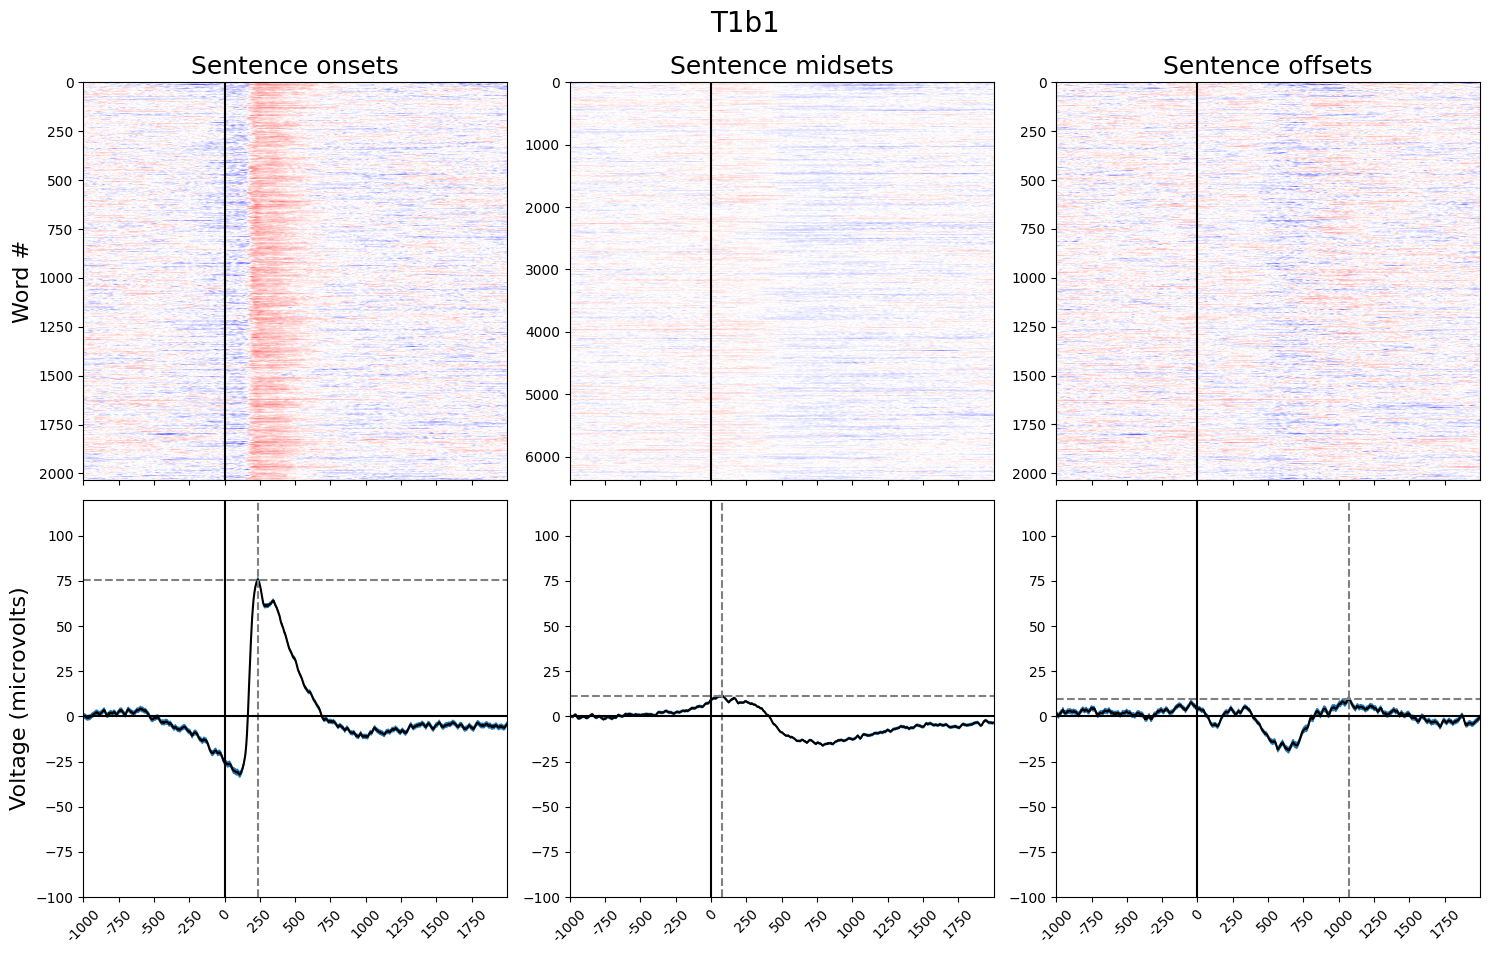

In [18]:
plot_overlaid_electrode_signal(word_windows_arr, words_df, electrode_label, window_duration, window_onset)

Now, let's plot the location of that electrode on an inflated brain

In [19]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

base_path = os.path.join(root_dir, 'localization')
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [t[0] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

In [20]:
def plot_hemisphere_axis(electrodes, ax=None, hemisphere="left", title=None):
    '''
    electrodes is a dict of format {<subject>: [<electrode>]}
    '''
    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img)
    elif hemisphere=="right":
        ax.imshow(right_hem_img)
    
    ax.axis('off')
    assert hemisphere in ["left", "right"]
    hem_index = 1 if hemisphere=="left" else 0

    plot_title = f'{hemisphere} hemisphere'
    
    if title:
        plot_title += f' {title}'
   
    all_x, all_y = [], []
    for s in electrodes:
        for e in electrodes[s]:
            x = list(scaled_coords_df[(scaled_coords_df.Subject == s) & (scaled_coords_df.Electrode == e) & (scaled_coords_df.Hemisphere==hem_index)]['X'])
            y = list(scaled_coords_df[(scaled_coords_df.Subject == s) & (scaled_coords_df.Electrode == e) & (scaled_coords_df.Hemisphere==hem_index)]['Y'])
            
            all_x += x
            all_y += y

    sc = ax.scatter(all_x,
                    all_y,
                    c='red',
                    s=100,
                    edgecolors='black')

In [21]:
def plot_hemispheres_separately(electrodes):
    fig, axs = plt.subplots(1, 2, figsize=(15,30))
    plot_hemisphere_axis(electrodes, ax=axs[0], hemisphere="right")
    plot_hemisphere_axis(electrodes, ax=axs[1], hemisphere="left")

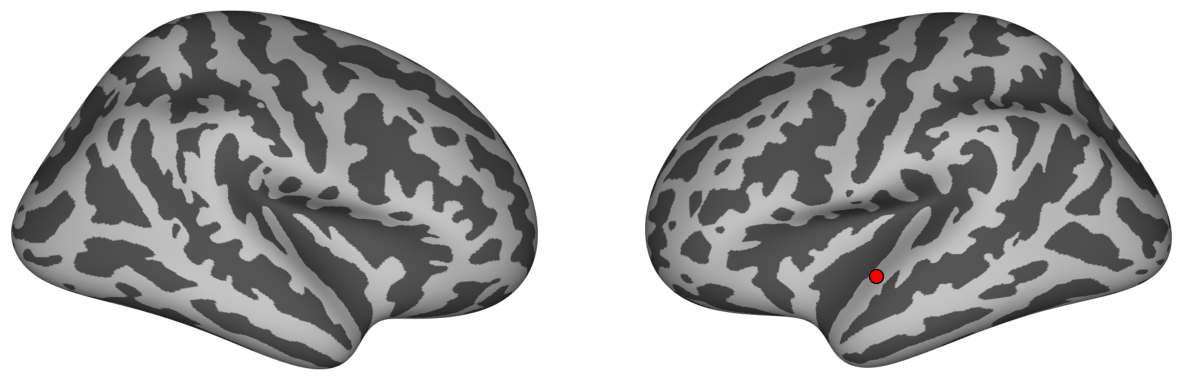

In [22]:
electrodes = {f"sub_{sub_id}": [electrode_label]}
plot_hemispheres_separately(electrodes)

In [23]:
word_windows_arr.shape

(1, 10118, 6144)